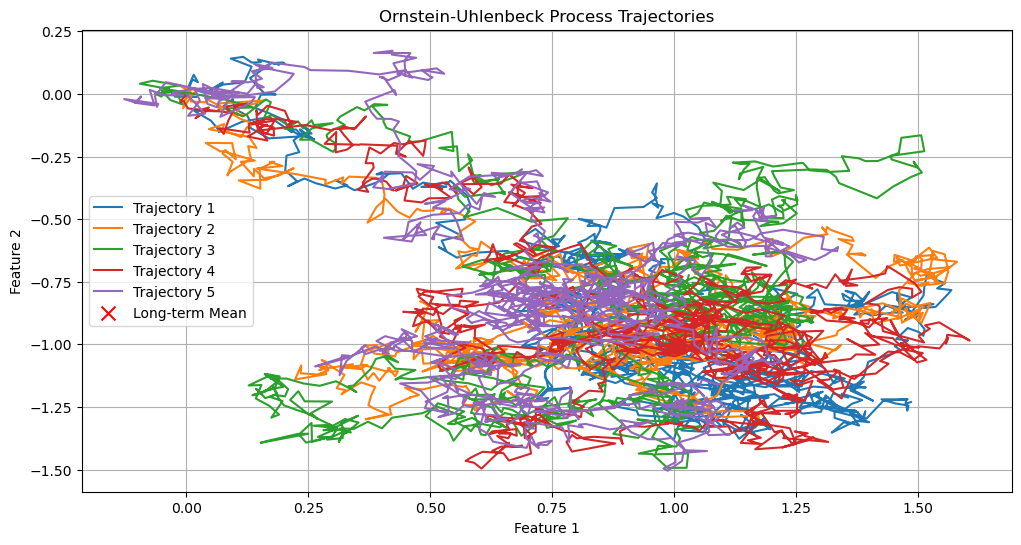

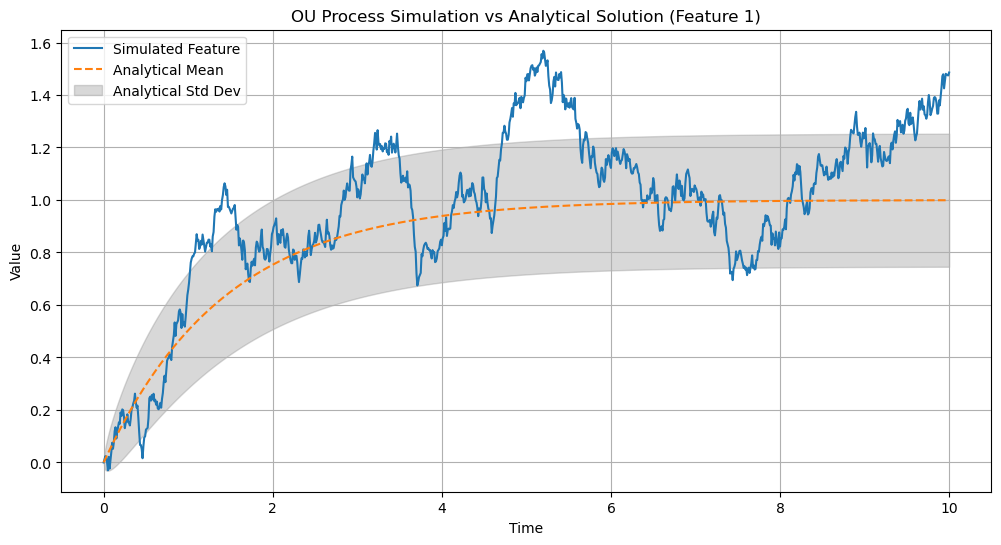

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

def ou_euler_maruyama(
    x0, 
    theta, 
    mu, 
    sigma, 
    T, 
    dt, 
    device="cuda:0", 
    return_all=False
):
    """
    Simulate the Ornstein-Uhlenbeck (OU) process using the Euler-Maruyama method.

    Args:
        x0 (torch.Tensor): Initial state. Shape: [batch_size, feature_dim].
        theta (float or torch.Tensor): Rate of mean reversion. Scalar or Shape: [batch_size, feature_dim].
        mu (torch.Tensor): Long-term mean. Shape: [batch_size, feature_dim].
        sigma (float or torch.Tensor): Volatility parameter. Scalar or Shape: [batch_size, feature_dim].
        T (int): Number of time steps.
        dt (float): Time step size.
        device (str, optional): Device to perform computations on. Defaults to "cuda:0".
        return_all (bool, optional): If True, return all intermediate states. Defaults to False.

    Returns:
        torch.Tensor or Tuple[torch.Tensor, torch.Tensor]:
            - If return_all is False: Final state after T steps. Shape: [batch_size, feature_dim].
            - If return_all is True: Tuple containing all states and all increments.
                - states: Shape [batch_size, feature_dim, T+1].
                - increments: Shape [batch_size, feature_dim, T].
    """
    # Move initial state and parameters to the specified device
    x = x0.to(device)
    mu = mu.to(device)
    
    # If theta and sigma are scalars, convert them to tensors
    if isinstance(theta, (float, int)):
        theta = torch.full_like(x, theta, device=device)
    else:
        theta = theta.to(device)
    
    if isinstance(sigma, (float, int)):
        sigma = torch.full_like(x, sigma, device=device)
    else:
        sigma = sigma.to(device)
    
    # Precompute sqrt(dt) for efficiency
    sqrt_dt = torch.sqrt(torch.tensor(dt, device=device))
    
    # Lists to store states and increments if required
    if return_all:
        x_all = [x.detach().cpu()]  # Initial state
        increments_all = []
    
    for step in range(T):
        # Generate random noise
        epsilon = torch.randn_like(x, device=device)
        
        # Compute deterministic and stochastic parts
        deterministic = theta * (mu - x) * dt
        stochastic = sigma * sqrt_dt * epsilon
        
        # Update state
        x = x + deterministic + stochastic
        
        if return_all:
            x_cpu = x.detach().cpu()
            x_all.append(x_cpu)
            increments_all.append(deterministic.detach().cpu() + stochastic.detach().cpu())
    
    if return_all:
        # Concatenate along the last dimension
        states = torch.stack(x_all, dim=-1)  # [batch_size, feature_dim, T+1]
        increments = torch.stack(increments_all, dim=-1)  # [batch_size, feature_dim, T]
        return states, increments
    else:
        return x.detach().cpu()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Set device
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    # Define parameters
    batch_size = 5        # Number of trajectories
    feature_dim = 2       # Dimensionality of each trajectory
    theta = 0.7           # Rate of mean reversion
    mu = torch.tensor([1.0, -1.0]).repeat(batch_size, 1)  # Long-term mean for each trajectory
    sigma = 0.3           # Volatility parameter
    T = 1000              # Number of time steps
    dt = 0.01             # Time step size
    
    # Initial state: start from zero
    x0 = torch.zeros(batch_size, feature_dim)
    
    # Simulate OU process
    states, increments = ou_euler_maruyama(
        x0, 
        theta, 
        mu, 
        sigma, 
        T, 
        dt, 
        device=device, 
        return_all=True
    )
    
    # states: [batch_size, feature_dim, T+1]
    # increments: [batch_size, feature_dim, T]
    
    # Move states to CPU for plotting
    states = states.numpy()
    
    # Plot the trajectories
    plt.figure(figsize=(12, 6))
    
    for i in range(batch_size):
        plt.plot(states[i, 0, :], states[i, 1, :], label=f'Trajectory {i+1}')
    
    # Plot the long-term mean
    plt.scatter(mu[0, 0].item(), mu[0, 1].item(), color='red', marker='x', s=100, label='Long-term Mean')
    
    plt.title("Ornstein-Uhlenbeck Process Trajectories")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Optional: Compare with Analytical Solution for Validation
    # For one trajectory and one feature
    selected_batch = 0
    selected_feature = 0  # Change to 1 for the second feature
    
    # Time array
    time = np.linspace(0, T*dt, T+1)
    
    # Analytical mean and variance
    mean_analytical = mu[selected_batch, selected_feature].item() * (1 - np.exp(-theta * time))
    variance_analytical = (sigma**2) / (2 * theta) * (1 - np.exp(-2 * theta * time))
    
    # Extract simulated data for the selected trajectory and feature
    simulated_data = states[selected_batch, selected_feature, :]
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(time, simulated_data, label='Simulated Feature')
    plt.plot(time, mean_analytical, label='Analytical Mean', linestyle='--')
    plt.fill_between(time, 
                     mean_analytical - np.sqrt(variance_analytical), 
                     mean_analytical + np.sqrt(variance_analytical),
                     color='gray', alpha=0.3, label='Analytical Std Dev')
    plt.title(f"OU Process Simulation vs Analytical Solution (Feature {selected_feature + 1})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

Final Mean: 1.9973, Target Mean: 2.0
Final Variance: 4.1031, Target Variance: 4.0


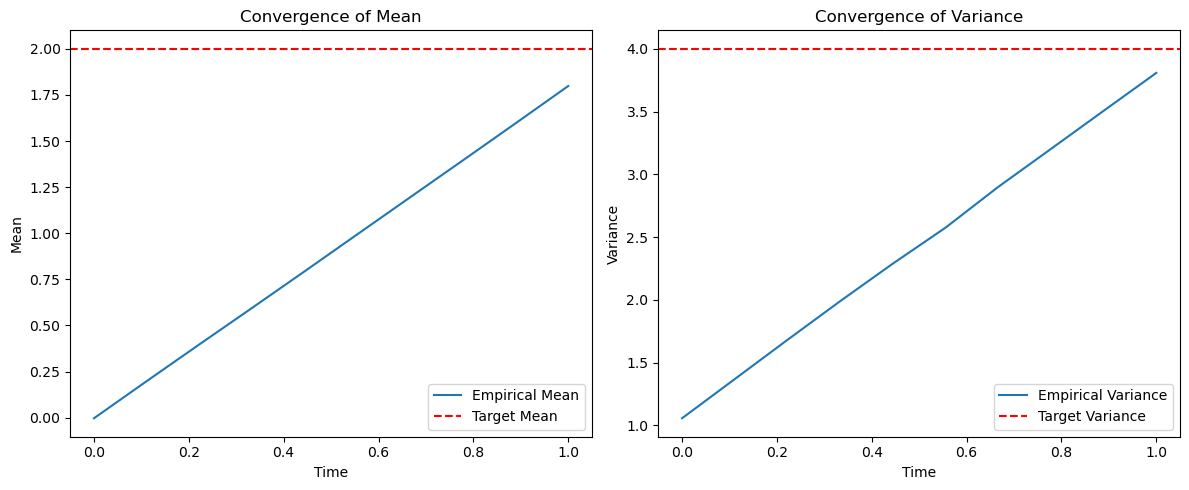

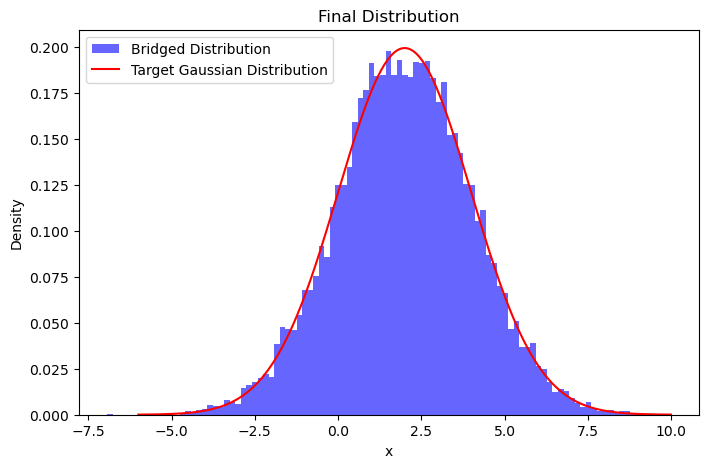

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
mu_0 = 0.0        # Initial mean
mu_T = 2.0        # Final mean
sigma0_sq = 1.0   # Initial variance
sigmaT_sq = 4.0   # Final variance
T = 1.0           # Total time
num_steps = 1000  # Number of time steps
dt = T / num_steps
time = np.linspace(0, T, num_steps)

# Define Mean Evolution (Linear)
def mean_t(t):
    return mu_0 + (mu_T - mu_0) * t / T

# Define Covariance Evolution (Linear)
def sigma_sq_t(t):
    return sigma0_sq + (sigmaT_sq - sigma0_sq) * t / T

# Precompute Drift Terms A(t) and b(t)
Sigma_t = sigma_sq_t(time)  # Covariance at each time step
dSigma_dt = (sigmaT_sq - sigma0_sq) / T  # Derivative of Sigma(t)

# Compute A(t) = [dSigma/dt - 1] / (2 * Sigma(t))
A_t = (dSigma_dt - 1.0) / (2.0 * Sigma_t)

# Compute b(t) = dm/dt - A(t) * m(t)
dm_dt = (mu_T - mu_0) / T
m_t = mean_t(time)
b_t = dm_dt - A_t * m_t

# Initialize Particles from Initial Distribution
num_particles = 10000
x = np.random.normal(mu_0, np.sqrt(sigma0_sq), num_particles)

# Arrays to Store Mean and Variance for Verification
means = []
variances = []

# Simulate the Schrödinger Bridge
for i in range(num_steps):
    t = time[i]
    drift = A_t[i] * x + b_t[i]
    noise = np.random.normal(0, np.sqrt(dt), num_particles)
    x += drift * dt + noise
    # Store mean and variance at every 100 steps for visualization
    if i % 100 == 0:
        means.append(np.mean(x))
        variances.append(np.var(x))

# Final Statistics
final_mean = np.mean(x)
final_variance = np.var(x)

print(f"Final Mean: {final_mean:.4f}, Target Mean: {mu_T}")
print(f"Final Variance: {final_variance:.4f}, Target Variance: {sigmaT_sq}")

# Plotting Convergence of Mean and Variance
plt.figure(figsize=(12, 5))

# Mean Convergence
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, T, len(means)), means, label='Empirical Mean')
plt.axhline(mu_T, color='r', linestyle='--', label='Target Mean')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.title('Convergence of Mean')
plt.legend()

# Variance Convergence
plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, T, len(variances)), variances, label='Empirical Variance')
plt.axhline(sigmaT_sq, color='r', linestyle='--', label='Target Variance')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Convergence of Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plot Histogram of Final Distribution
plt.figure(figsize=(8, 5))
plt.hist(x, bins=100, density=True, alpha=0.6, color='blue', label='Bridged Distribution')

# Define Target Bimodal Distribution (if needed)
# For Gaussian Bridge, it's unimodal. If you have a bimodal target, adjust accordingly.

# Since in the Gaussian bridge example we have a unimodal target, plot the target Gaussian
from scipy.stats import norm
x_vals = np.linspace(mu_T - 4*np.sqrt(sigmaT_sq), mu_T + 4*np.sqrt(sigmaT_sq), 1000)
p_target = norm.pdf(x_vals, loc=mu_T, scale=np.sqrt(sigmaT_sq))
plt.plot(x_vals, p_target, 'r-', label='Target Gaussian Distribution')

plt.title('Final Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()